In [1]:
import ann_visualizer
import copy
import datetime
from IPython.display import display, Image
import json
import logging
import matplotlib.pyplot as plt
import numpy
import os
import pandas
import pdb
import pickle
import plotly
import pyarrow.parquet as pq
import random
import requests
import six
import slack
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, Dropout, BatchNormalization
import time

import CS230

plotly.offline.init_notebook_mode(connected=True)
#tf.enable_eager_execution()

# model 7: LSTM

In [2]:
MODEL_NAME = 'model-7'
MODEL_DIR = os.path.join('models', MODEL_NAME)
RESULTS_FILE_PATH = os.path.join(MODEL_DIR, 'results.csv')
EPOCHS = 150
SLACK_WEBHOOK_URL = os.environ['SLACK_WEBHOOK_URL']

logger = CS230.common.get_logger()

In [3]:
#TODO upload image to training error

def slack_post(text, image=None):
    data = {
        'text': datetime.datetime.now().strftime("%H:%M:%S ") + text,
        'username': 'training',
        'icon_emoji': ':robot_face:'
    }
    
    response = requests.post(SLACK_WEBHOOK_URL, data=json.dumps(data), headers={'Content-Type': 'application/json'})
    print('Response: ' + str(response.text))
    print('Response code: ' + str(response.status_code))

# load and format data

In [4]:
FILE_PATHS = []

for dir_path, dir_names, file_names in os.walk(CS230.data.DATA_DIR):
    if dir_path.startswith('.'):
        continue
    
    for file_name in file_names:
        if file_name.endswith('.parquet'):
            file_path = os.path.join(dir_path, file_name)
            FILE_PATHS.append(file_path)
    
    if FILE_PATHS:
        break  # exit after loading files from 1 directory

FILE_PATHS.sort()
FILE_PATHS

['/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_02_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_03_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_04_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222

In [5]:
COLS_X = {
    'x1': ['axCG', 'ayCG', 'azCG', 'brake', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR', 
          'clutch', 'handwheelAngle', 'deflectionFL', 'deflectionFR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'throttle', 'vxCG', 'vyCG', 'vzCG', 
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate'],
    
    'x2': ['brake', 'clutch', 'handwheelAngle', 'throttle',
           'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate',
           'vxCG', 'vyCG', 'vzCG', 'yawAngle', 'yawRate'],
    
    'x3': ['brake', 'clutch', 'handwheelAngle', 'throttle',
           'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'yawAngle', 'yawRate',
           'vxCG', 'vyCG', 'vzCG', 'axCG', 'ayCG', 'azCG',
           'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
    
    'all': CS230.data.COLUMNS_ALL,
}

COLS_Y = {
    'y1': ['axCG', 'ayCG', 'azCG', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR',
          'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate'],
    
    'y2': ['pitchAngle', 'rollAngle', 'vxCG', 'vyCG', 'vzCG',
          'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle'],
    
    'y3': ['pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'yawAngle', 'yawRate',
           'vxCG', 'vyCG', 'vzCG', 'axCG', 'ayCG', 'azCG',
           'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
    
    'y4': ['pitchAngle', 'rollAngle', 'yawAngle',
           'vxCG', 'vyCG', 'vzCG',
           'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
    
    'y5': ['rollAngle', 'yawAngle', 'vxCG', 'vyCG', 'vzCG'],
}

In [6]:
def get_df(file_path, cols_x, cols_y):
    cols_all = copy.deepcopy(cols_x)
    cols_all.extend(cols_y)
    cols_all = list(set(cols_all))  # reduce to unique
    
    df = CS230.data.load(file_path)[cols_all]
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)
    
    df_x = copy.deepcopy(df)[cols_x]
    df_x = df_x.iloc[:-1].reset_index(drop=True)
    
    df_y = copy.deepcopy(df)[cols_y]
    df_y = df_y.iloc[1:].reset_index(drop=True)
    
    return df_x, df_y

# get data

In [7]:
data_name = 'train'

In [8]:
def get_data(cols_x, cols_y, sequence_length, num_data_files):
    DATA = {}
    DATA[data_name] = {
        'df': {
            'x': pandas.DataFrame(columns=COLS_X[cols_x]),
            'y': pandas.DataFrame(columns=COLS_Y[cols_y])
        }
    }

    for i in range(num_data_files):
        file_path = FILE_PATHS[i]

        df_x, df_y = get_df(file_path, cols_x=COLS_X[cols_x], cols_y=COLS_Y[cols_y])
        
        DATA[data_name]['df']['x'] = pandas.concat([DATA[data_name]['df']['x'], df_x], ignore_index=True, sort=False)
        
        DATA[data_name]['df']['y'] = pandas.concat([DATA[data_name]['df']['y'], df_y], ignore_index=True, sort=False)
        
        print(i, DATA[data_name]['df']['x'].shape)
        print(i, DATA[data_name]['df']['y'].shape)

    DATA[data_name]['generator'] = tf.keras.preprocessing.sequence.TimeseriesGenerator(
                                    DATA[data_name]['df']['x'].values,
                                    DATA[data_name]['df']['y'].values,
                                    length=sequence_length, sampling_rate=1  #, shuffle=True
    )
    
    return DATA

# build models

In [9]:
PARAMS = []
for sequence_length in [200]:
    for cols_x in ['all']:
        for cols_y in ['y5']:
            for learning_rate in [8e-3, 5e-3]:
                for learning_rate_decay in [5e-5, 3e-5, 1e-5]:
                    for batch_norm in [False]:
                        for dropout in [0.1]:
                            for lstm_units in [sequence_length]:
                                for num_data_files in [4]:
                                    params = {
                                        'sequence_length': int(sequence_length),
                                        'cols_x': cols_x,
                                        'cols_y': cols_y,
                                        'learning_rate': float(learning_rate),
                                        'learning_rate_decay': float(learning_rate_decay),
                                        'batch_norm': batch_norm,
                                        'dropout': float(dropout),
                                        'lstm_units': int(lstm_units),
                                        'num_data_files': num_data_files,
                                        '2nd_LSTM_layer': False
                                        }
                                    PARAMS.append(params)

In [10]:
# TODO output sigmoid with multiplier for range
# TODO reduce to 1 output at a time to fully understand what result means
# TODO expand size of input data set
# TODO convert data load from pd.dataframe to np.array

5 from 6
0 (49095, 54)
0 (49095, 5)
1 (128194, 54)
1 (128194, 5)
2 (128194, 54)
2 (128194, 5)
3 (128194, 54)
3 (128194, 5)


00-37-51 | INFO | models/model-7/20190608003751
00-37-51 | INFO | {'sequence_length': 200, 'cols_x': 'all', 'cols_y': 'y5', 'learning_rate': 0.005, 'learning_rate_decay': 1e-05, 'batch_norm': False, 'dropout': 0.1, 'lstm_units': 200, 'num_data_files': 4, '2nd_LSTM_layer': False}


Response: ok
Response code: 200
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               204000    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 205,005
Trainable params: 205,005
Non-trainable params: 0
_________________________________________________________________


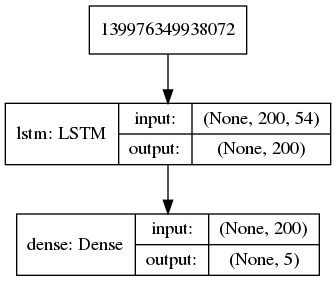

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
 999/1000 [============================>.] - ETA: 0s - loss: 1305.3427 - mean_absolute_error: 13.2151
Epoch 00001: loss improved from inf to 1305.96184, saving model to models/model-7/20190608003751/epoch1.h5
1000/1000 [==============================] - 186s 186ms/step - loss: 1305.9010 - mean_absolute_error: 13.2219
Epoch 2/150
 999/1000 [============================>.] - ETA: 0s - loss: 1288.7334 - mean_absolute_error: 13.5414
Epoch 00002: loss improved from 1305.96184 to 1287.62262, saving model to models/model-7/20190608003751/epoch2.h5
1000/1000 [==============================] - 184s 184ms/step - loss: 1287.5670 - mean_absolute_error: 13.5345
Epoch 3/150
 999/1000 [============================>.] - ETA: 0s - loss: 1282.6374 - mean_absolute_error: 13.6871
Epoch 00003: loss improved from 1287.62262 to 1281.49227, saving model to models/model-7/20190608003751/epoch3.h5
1000/10

Epoch 25/150
 999/1000 [============================>.] - ETA: 0s - loss: 1213.6546 - mean_absolute_error: 13.0747
Epoch 00025: loss improved from 1218.09419 to 1212.59305, saving model to models/model-7/20190608003751/epoch25.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 1212.5412 - mean_absolute_error: 13.0678
Epoch 26/150
 999/1000 [============================>.] - ETA: 0s - loss: 1201.4348 - mean_absolute_error: 13.0363
Epoch 00026: loss improved from 1212.59305 to 1200.45077, saving model to models/model-7/20190608003751/epoch26.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 1200.3992 - mean_absolute_error: 13.0309
Epoch 27/150
 999/1000 [============================>.] - ETA: 0s - loss: 1196.9598 - mean_absolute_error: 13.1133
Epoch 00027: loss improved from 1200.45077 to 1196.26576, saving model to models/model-7/20190608003751/epoch27.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 1196.2150 - mean_abso

Epoch 50/150
 999/1000 [============================>.] - ETA: 0s - loss: 1077.0120 - mean_absolute_error: 12.2843
Epoch 00050: loss improved from 1076.89870 to 1076.33204, saving model to models/model-7/20190608003751/epoch50.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 1076.2887 - mean_absolute_error: 12.2817
Epoch 51/150
 999/1000 [============================>.] - ETA: 0s - loss: 1067.6627 - mean_absolute_error: 12.0810
Epoch 00051: loss improved from 1076.33204 to 1066.70188, saving model to models/model-7/20190608003751/epoch51.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 1066.6588 - mean_absolute_error: 12.0733
Epoch 52/150
 999/1000 [============================>.] - ETA: 0s - loss: 1088.4906 - mean_absolute_error: 12.7490
Epoch 00052: loss did not improve from 1066.70188
1000/1000 [==============================] - 183s 183ms/step - loss: 1087.5931 - mean_absolute_error: 12.7429
Epoch 53/150
 999/1000 [=====================

Epoch 77/150
 999/1000 [============================>.] - ETA: 0s - loss: 1027.6636 - mean_absolute_error: 11.8218
Epoch 00077: loss did not improve from 1025.99449
1000/1000 [==============================] - 183s 183ms/step - loss: 1026.7169 - mean_absolute_error: 11.8145
Epoch 78/150
 999/1000 [============================>.] - ETA: 0s - loss: 1038.4576 - mean_absolute_error: 12.0325
Epoch 00078: loss did not improve from 1025.99449
1000/1000 [==============================] - 183s 183ms/step - loss: 1037.5501 - mean_absolute_error: 12.0273
Epoch 79/150
 999/1000 [============================>.] - ETA: 0s - loss: 1027.7220 - mean_absolute_error: 11.9155
Epoch 00079: loss did not improve from 1025.99449
1000/1000 [==============================] - 183s 183ms/step - loss: 1026.8524 - mean_absolute_error: 11.9112
Epoch 80/150
 999/1000 [============================>.] - ETA: 0s - loss: 1023.8513 - mean_absolute_error: 11.9539
Epoch 00080: loss improved from 1025.99449 to 1022.98407, sa

Epoch 105/150
 999/1000 [============================>.] - ETA: 0s - loss: 956.9755 - mean_absolute_error: 11.2458
Epoch 00105: loss improved from 973.31329 to 959.45242, saving model to models/model-7/20190608003751/epoch105.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 959.4123 - mean_absolute_error: 11.2592
Epoch 106/150
 999/1000 [============================>.] - ETA: 0s - loss: 957.5421 - mean_absolute_error: 11.2100
Epoch 00106: loss improved from 959.45242 to 956.70527, saving model to models/model-7/20190608003751/epoch106.h5
1000/1000 [==============================] - 183s 183ms/step - loss: 956.6655 - mean_absolute_error: 11.2039
Epoch 107/150
 999/1000 [============================>.] - ETA: 0s - loss: 970.5834 - mean_absolute_error: 11.4289
Epoch 00107: loss did not improve from 956.70527
1000/1000 [==============================] - 183s 183ms/step - loss: 969.8043 - mean_absolute_error: 11.4256
Epoch 108/150
 999/1000 [==========================

 999/1000 [============================>.] - ETA: 0s - loss: 812.8607 - mean_absolute_error: 10.2204
Epoch 00131: loss did not improve from 807.80884
1000/1000 [==============================] - 183s 183ms/step - loss: 812.0932 - mean_absolute_error: 10.2139
Epoch 00131: early stopping
Response: ok
Response code: 200


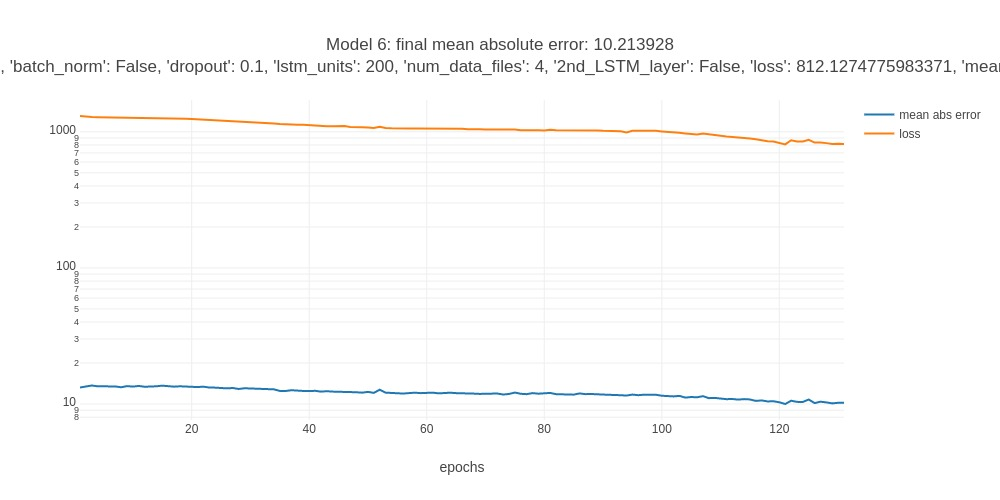

4 from 6
0 (49095, 54)
0 (49095, 5)
1 (128194, 54)
1 (128194, 5)
2 (128194, 54)
2 (128194, 5)
3 (128194, 54)
3 (128194, 5)


07-17-46 | INFO | models/model-7/20190608071746
INFO:CS230:models/model-7/20190608071746
07-17-46 | INFO | {'sequence_length': 200, 'cols_x': 'all', 'cols_y': 'y5', 'learning_rate': 0.005, 'learning_rate_decay': 3e-05, 'batch_norm': False, 'dropout': 0.1, 'lstm_units': 200, 'num_data_files': 4, '2nd_LSTM_layer': False}
INFO:CS230:{'sequence_length': 200, 'cols_x': 'all', 'cols_y': 'y5', 'learning_rate': 0.005, 'learning_rate_decay': 3e-05, 'batch_norm': False, 'dropout': 0.1, 'lstm_units': 200, 'num_data_files': 4, '2nd_LSTM_layer': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               204000    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 205,005
Trainable params: 205,005
Non-trainable params: 0
_________________________________________________________________


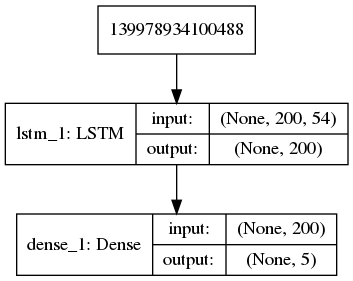

Epoch 1/150
 999/1000 [============================>.] - ETA: 0s - loss: 1304.3704 - mean_absolute_error: 13.2400
Epoch 00001: loss improved from inf to 1303.30854, saving model to models/model-7/20190608071746/epoch1.h5
1000/1000 [==============================] - 187s 187ms/step - loss: 1303.2518 - mean_absolute_error: 13.2339
Epoch 2/150
 999/1000 [============================>.] - ETA: 0s - loss: 1284.8921 - mean_absolute_error: 13.4076
Epoch 00002: loss improved from 1303.30854 to 1283.82217, saving model to models/model-7/20190608071746/epoch2.h5
1000/1000 [==============================] - 187s 187ms/step - loss: 1283.7700 - mean_absolute_error: 13.4024
Epoch 3/150
 999/1000 [============================>.] - ETA: 0s - loss: 1280.5171 - mean_absolute_error: 13.6463
Epoch 00003: loss improved from 1283.82217 to 1280.93671, saving model to models/model-7/20190608071746/epoch3.h5
1000/1000 [==============================] - 187s 187ms/step - loss: 1280.8824 - mean_absolute_error: 1

Epoch 26/150
 999/1000 [============================>.] - ETA: 0s - loss: 1132.7009 - mean_absolute_error: 12.2422
Epoch 00026: loss improved from 1144.51642 to 1136.40906, saving model to models/model-7/20190608071746/epoch26.h5
1000/1000 [==============================] - 187s 187ms/step - loss: 1136.3606 - mean_absolute_error: 12.2662
Epoch 27/150
 999/1000 [============================>.] - ETA: 0s - loss: 1134.9320 - mean_absolute_error: 12.2541
Epoch 00027: loss improved from 1136.40906 to 1133.96390, saving model to models/model-7/20190608071746/epoch27.h5
1000/1000 [==============================] - 187s 187ms/step - loss: 1133.9152 - mean_absolute_error: 12.2484
Epoch 28/150
 999/1000 [============================>.] - ETA: 0s - loss: 1115.1697 - mean_absolute_error: 12.4591
Epoch 00028: loss improved from 1133.96390 to 1114.71984, saving model to models/model-7/20190608071746/epoch28.h5
1000/1000 [==============================] - 187s 187ms/step - loss: 1114.6736 - mean_abso

Epoch 51/150
 999/1000 [============================>.] - ETA: 0s - loss: 1022.1403 - mean_absolute_error: 11.8334
Epoch 00051: loss did not improve from 1022.41763
1000/1000 [==============================] - 189s 189ms/step - loss: 1024.9740 - mean_absolute_error: 11.8500
Epoch 52/150
 999/1000 [============================>.] - ETA: 0s - loss: 1024.3198 - mean_absolute_error: 11.7646
Epoch 00052: loss did not improve from 1022.41763
1000/1000 [==============================] - 191s 191ms/step - loss: 1023.3808 - mean_absolute_error: 11.7580
Epoch 53/150
 999/1000 [============================>.] - ETA: 0s - loss: 1019.3732 - mean_absolute_error: 11.6827
Epoch 00053: loss improved from 1022.41763 to 1018.56958, saving model to models/model-7/20190608071746/epoch53.h5
1000/1000 [==============================] - 190s 190ms/step - loss: 1018.5277 - mean_absolute_error: 11.6773
Epoch 54/150
 999/1000 [============================>.] - ETA: 0s - loss: 1015.6775 - mean_absolute_error: 11.

 999/1000 [============================>.] - ETA: 0s - loss: 1000.7466 - mean_absolute_error: 11.5600
Epoch 00078: loss did not improve from 988.89092
1000/1000 [==============================] - 188s 188ms/step - loss: 1000.0893 - mean_absolute_error: 11.5594
Epoch 79/150
 999/1000 [============================>.] - ETA: 0s - loss: 999.0111 - mean_absolute_error: 11.4985
Epoch 00079: loss did not improve from 988.89092
1000/1000 [==============================] - 193s 193ms/step - loss: 998.1149 - mean_absolute_error: 11.4928
Epoch 80/150
 999/1000 [============================>.] - ETA: 0s - loss: 993.0791 - mean_absolute_error: 11.4638
Epoch 00080: loss did not improve from 988.89092
1000/1000 [==============================] - 188s 188ms/step - loss: 992.1971 - mean_absolute_error: 11.4579
Epoch 81/150
 999/1000 [============================>.] - ETA: 0s - loss: 991.1848 - mean_absolute_error: 11.5463
Epoch 00081: loss did not improve from 988.89092
1000/1000 [=====================

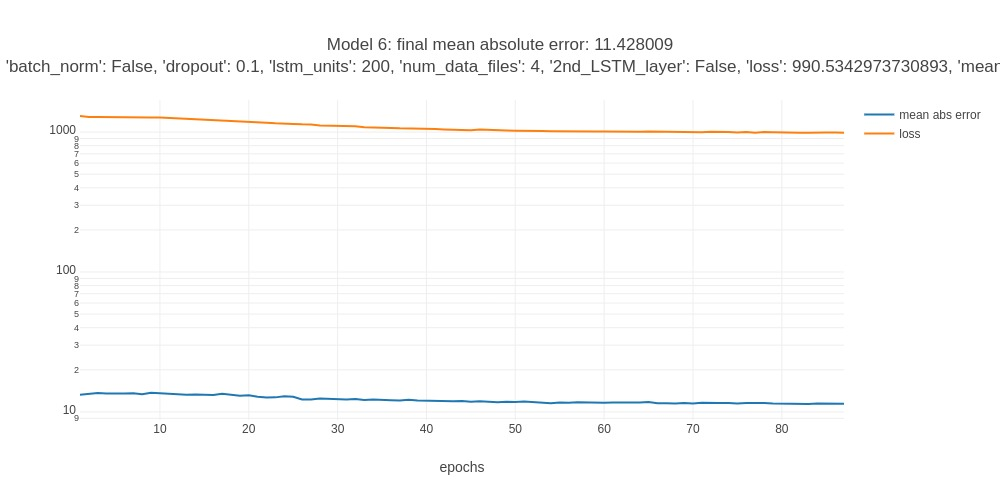

2 from 6
0 (49095, 54)
0 (49095, 5)
1 (128194, 54)
1 (128194, 5)
2 (128194, 54)
2 (128194, 5)
3 (128194, 54)
3 (128194, 5)


11-50-17 | INFO | models/model-7/20190608115017
INFO:CS230:models/model-7/20190608115017
11-50-17 | INFO | {'sequence_length': 200, 'cols_x': 'all', 'cols_y': 'y5', 'learning_rate': 0.008, 'learning_rate_decay': 1e-05, 'batch_norm': False, 'dropout': 0.1, 'lstm_units': 200, 'num_data_files': 4, '2nd_LSTM_layer': False}
INFO:CS230:{'sequence_length': 200, 'cols_x': 'all', 'cols_y': 'y5', 'learning_rate': 0.008, 'learning_rate_decay': 1e-05, 'batch_norm': False, 'dropout': 0.1, 'lstm_units': 200, 'num_data_files': 4, '2nd_LSTM_layer': False}


Response: ok
Response code: 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               204000    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total params: 205,005
Trainable params: 205,005
Non-trainable params: 0
_________________________________________________________________


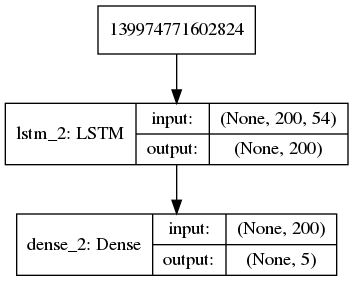

Epoch 1/150
 999/1000 [============================>.] - ETA: 0s - loss: 1302.7327 - mean_absolute_error: 13.3943
Epoch 00001: loss improved from inf to 1301.55295, saving model to models/model-7/20190608115017/epoch1.h5
1000/1000 [==============================] - 188s 188ms/step - loss: 1301.4967 - mean_absolute_error: 13.3862
Epoch 2/150
 999/1000 [============================>.] - ETA: 0s - loss: 1285.9117 - mean_absolute_error: 13.4158
Epoch 00002: loss improved from 1301.55295 to 1284.82339, saving model to models/model-7/20190608115017/epoch2.h5
1000/1000 [==============================] - 186s 186ms/step - loss: 1284.7678 - mean_absolute_error: 13.4093
Epoch 3/150
 999/1000 [============================>.] - ETA: 0s - loss: 1283.2303 - mean_absolute_error: 13.6174
Epoch 00003: loss improved from 1284.82339 to 1284.14471, saving model to models/model-7/20190608115017/epoch3.h5
1000/1000 [==============================] - 186s 186ms/step - loss: 1284.0922 - mean_absolute_error: 1

KeyboardInterrupt: 

In [11]:
# load prior param results
if os.path.exists(RESULTS_FILE_PATH):
    df_results = pandas.read_csv(RESULTS_FILE_PATH)
else:
    df_results = pandas.DataFrame()
best_params_path = os.path.join(MODEL_DIR, 'best_params.json')
with open(best_params_path, 'r') as f:
    best_params = json.load(f)

# randomize param selection
random_indexes = list(range(len(PARAMS)))
random.shuffle(random_indexes)
    
# train
for i in random_indexes:
    print('%s from %s' % (i, len(PARAMS)))
    params = PARAMS[i]
    
    cols_x = params['cols_x']
    cols_y = params['cols_y']
    sequence_length = params['sequence_length']
    learning_rate = params['learning_rate']
    learning_rate_decay = params['learning_rate_decay']
    batch_norm = params['batch_norm']
    dropout = params['dropout']
    lstm_units = params['lstm_units']
    num_data_files = params['num_data_files']

    try:
        # load data
        DATA = get_data(cols_x, cols_y, sequence_length, num_data_files)
        m = DATA[data_name]['df']['x'].shape[0]
        n_x = DATA[data_name]['df']['x'].shape[1]
        n_y = DATA[data_name]['df']['y'].shape[1]
        
        # check if already tried these params
        isin_map = {}
        keys = []
        for key, val in six.iteritems(params):
            isin_map[key] = [val]
            keys.append(key)
        try:
            if not df_results.empty and (True in df_results[keys].isin(isin_map).all(axis=1).values):
                logging.warning('skipping, already in results: %s', params)
                continue
        except KeyError as e:
            logging.exception(e)
        
        # init directories
        dt_start = datetime.datetime.now()
        SESS_DATE_TIME = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        SESS_DIR = os.path.join(MODEL_DIR, SESS_DATE_TIME)
        for dir_path in [MODEL_DIR, SESS_DIR]:
            if not os.path.isdir(dir_path):
                os.mkdir(dir_path)
        with open(os.path.join(SESS_DIR, 'params.json'), 'w') as f:
            json.dump(params, f)

        # log start
        logger.info(SESS_DIR)
        logger.info(params)
        slack_post(text='`%s` params : %s' % (SESS_DIR, params))

        # build model
        model = tf.keras.Sequential()

        if batch_norm:
            model.add(BatchNormalization(input_shape=(sequence_length, n_x)))

        model.add(LSTM(lstm_units, return_sequences=False, input_shape=(sequence_length, n_x),
                       dropout=dropout, recurrent_dropout=dropout))

        #model.add(LSTM(lstm_units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))

        model.add(tf.keras.layers.Dense(n_y, activation='linear'))

        # summarize model
        model.summary()

        # visualize model
        file_path = os.path.join(SESS_DIR, 'architecture.png')
        tf.keras.utils.plot_model(model, file_path, show_shapes=True, show_layer_names=True)
        display(Image(filename=file_path))

        # set optimizer
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=learning_rate_decay)
        #optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

        # compile model
        model.compile(
            optimizer=optimizer, 
            loss='mean_squared_error', 
            metrics=['mean_absolute_error']
        )

        # set callbacks
        file_path = os.path.join(SESS_DIR, 'epoch{epoch}.h5')
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(file_path, monitor='loss', 
                            verbose=1, save_weights_only=True, save_best_only=True, mode='min')
        stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-2, patience=10, verbose=1)
        callbacks = [checkpoint_callback, stop_callback]

        # train model
        history = model.fit_generator(
            DATA['train']['generator'], 
            epochs=EPOCHS, 
            steps_per_epoch=len(DATA['train']['generator']), 
            callbacks=callbacks
        )

        # save model
        file_name = 'model_end_%s.h5' % history.history['mean_absolute_error'][-1]
        model.save(os.path.join(SESS_DIR, file_name))

        # save time
        dt_delta = datetime.datetime.now() - dt_start
        total_time = '%s:%s' % (int(dt_delta.total_seconds() / 60), round(dt_delta.total_seconds() % 60))

        # save results 
        params['loss'] = float(history.history['loss'][-1])
        params['mean_absolute_error'] = float(history.history['mean_absolute_error'][-1])
        params['session'] = SESS_DIR
        params['time'] = total_time
        if df_results.empty:
            df_results = pandas.DataFrame([params])
        else:
            df_results = pandas.concat([df_results, pandas.DataFrame([params])], 
                                       ignore_index=True, sort=False).reset_index(drop=True)
        df_results.to_csv(RESULTS_FILE_PATH)

        # post result to slack
        slack_post(text='`%s` time : `%s`, error : *%s*, loss: *%s*' % (SESS_DIR, total_time,
               history.history['mean_absolute_error'][-1], history.history['loss'][-1]))

        # save best params
        if history.history['mean_absolute_error'][-1] < best_params['mean_absolute_error']:
            best_params = copy.deepcopy(params)

            slack_post(text='`%s` :bananadance: best' % (SESS_DIR))

            with open(best_params_path, 'w') as f:
                json.dump(best_params, f)

        # plot error
        file_path = os.path.join(SESS_DIR, 'training_error.jpeg')
        title = 'Model 6: final mean absolute error: %s<br>%s' % (
            history.history['mean_absolute_error'][-1],
            params
        )
        trace_mae = plotly.graph_objs.Scatter(
            x=list(range(1, len(pandas.DataFrame(history.history['mean_absolute_error']))+1)),
            y=history.history['mean_absolute_error'],
            name='mean abs error'
        )
        trace_loss = plotly.graph_objs.Scatter(
            x=list(range(1, len(pandas.DataFrame(history.history['loss']))+1)),
            y=history.history['loss'],
            name='loss'
        )
        layout = plotly.graph_objs.Layout(
            title=title,
            xaxis=dict(title='epochs'),
            yaxis=dict(type='log')
        )
        fig = plotly.graph_objs.Figure(data=[trace_mae, trace_loss], layout=layout)

        # save plot to file
        plotly.io.write_image(fig, file_path, width=1000, height=500)

        # display plot from file
        display(Image(filename=file_path))

        logging.info('best params: %s', best_params)

    except Exception as e:
        logger.exception(e)
        slack_post(text=':facepalm: `%s`' % str(e))

    try:
        del model
        del params
        del history
    except Exception as e:
        logger.exception(e)